# Validate

In [1]:
import os
import pickle
import json
from pathlib import Path
from typing import Sequence
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from numpy import typing as npt
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import statsmodels.api as sm

### Load Data

In [2]:
list_percentage_leaderboard = [
	2435, 2445, 2454, 2464, 2467, 2478, 2549, 2762, 2860, 3507, 3526, 3928, 4493,
	2489, 3353, 3366, 3509,
	2551, 2667, 2749, 3064, 3080, 3288, 3338, 3517, 3641, 3774, 3800, 3926, 3929,
	3960, 4031, 4043, 4104, 4366, 4407, 4453, 4477, 4488, 4657, 4699, 4986, 5056,
	5144, 5174, 5229, 5261, 5357, 5390, 5497, 6322, 6927, 7115
]

In [3]:
wd = os.getcwd()
wd_data = Path(os.path.join(wd, '__jsondata__'))
lst_data_json = list(wd_data.glob("*.json"))
len(lst_data_json)

69

In [4]:
contests_data = {
	'contest_id' : [],
	'data_json' : [],
	'data_post' : []
}

for path_json in lst_data_json:
	path_post = path_json.with_suffix(".pkl")
	contest_id = int(path_json.stem.split('_')[1])
	if contest_id not in list_percentage_leaderboard:
		continue
	with open(path_json, "r", encoding="utf-8") as f:
		data_json = json.load(f)
	if not path_post.exists():
		continue
	with open(path_post, "rb") as f:
		data_post = pickle.load(f)
	contests_data['contest_id'].append(int(contest_id))
	contests_data['data_json'].append(data_json)
	contests_data['data_post'].append(data_post)

print(contests_data['contest_id'])

[2762, 3353, 2489, 3774, 3929, 4366, 3509, 2549, 2749, 2860, 3288, 3928, 3338, 3800, 4493, 3507, 4104, 4407, 2435, 3064, 4488, 3526, 3926, 2478, 2454, 3960, 3366, 2445, 3080, 3517, 2464, 4477]


In [5]:
list(contests_data['data_json'][0].keys())

['start_time',
 'theta',
 'percentage',
 'max_daily_submit',
 'ratio',
 'N_Delta',
 'Delta2f',
 'Ni',
 'Nj',
 'hat_t_i',
 'hat_t_j',
 'hat_y',
 'real_y']

In [6]:
list(contests_data['data_post'][0].keys())

['mu_0',
 'c_i',
 'c_j',
 'sigma',
 'lambda',
 'r',
 'm_i',
 'm_j',
 'tilde_y',
 'intensity_i',
 'intensity_i_at_events',
 'intensity_j',
 'intensity_j_at_events',
 'effort_gap',
 'hat_y_mean',
 'hat_y_cov']

### Display Data

In [7]:
def plot_ts_events(
		time_grids: Sequence[datetime],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		ts_colors,
		ts_linestyles,
		*,
		ylim=None,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios,
	)
	if ylim is not None:
		ax_main.set_ylim(ylim[0], ylim[1])
	# plot time series
	idx_line = 0
	for ts_key, ts_val in ts.items():
		ax_main.plot(
			time_grids, ts_val, label=ts_key,
			color=ts_colors[idx_line],
			linestyle=ts_linestyles[idx_line],
		)
		idx_line += 1
	ax_main.legend(frameon=False)
	ax_main.xaxis.set_major_locator(MaxNLocator(nbins=8))
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1], color='black')
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height, color='black')
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

def plot_contest_data(contest_id: int):
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]
	contest_data_post = contests_data['data_post'][contest_idx]
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	N_Delta = contest_data_json['N_Delta']
	time_grids = [start_time + i * timedelta(hours=1) for i in range(N_Delta)]
	arr_hat_y = contest_data_json['hat_y']
	arr_real_y = contest_data_json['real_y']
	arr_tilde_y = contest_data_post['tilde_y'].mean(axis=0)
	hat_t_i = [start_time + timedelta(hours=t) for t in contest_data_json['hat_t_i']]
	hat_t_j = [start_time + timedelta(hours=t) for t in contest_data_json['hat_t_j']]
	#print(len(time_grids), len(arr_tilde_y))
	fig, ax_main, ax_events = plot_ts_events(
		time_grids=time_grids,
		ts={
			r'real output gap ($y_t$)': arr_real_y,
			r'observed output gap ($\hat{y}_t$)': arr_hat_y,
			r'perceived output gap ($\tilde{y}_t$)': arr_tilde_y[:-1],
		},
		events={
			r'player $i$': hat_t_i,
			r'player $j$': hat_t_j,
		},
		ts_colors = ['blue', 'black', 'black'],
		ts_linestyles=['solid', 'solid', 'dashed']
	)
	return fig, ax_main, ax_events

def plot_post_efforts(contest_id: int):
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]
	contest_data_post = contests_data['data_post'][contest_idx]
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	N_Delta = contest_data_json['N_Delta']
	time_grids = [start_time + i * timedelta(hours=1) for i in range(N_Delta)]
	i_effort_dynamic = contest_data_post['m_i'].mean(axis=0)
	j_effort_dynamic = contest_data_post['m_j'].mean(axis=0)
	plt.figure(figsize=(10, 3))
	plt.plot(np.array(time_grids), i_effort_dynamic, label='player i')
	plt.plot(np.array(time_grids), j_effort_dynamic, label='player j')
	plt.legend()
	plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8))
	plt.show()

In [8]:
def calculate_lambda_mle(arr_hat_y, arr_real_y, Delta2f):
	"""
	"""
	n = len(arr_hat_y)
	mse = sum([(hat_y - y)**2 for hat_y, y in zip(arr_hat_y, arr_real_y)])
	return n / mse / Delta2f

def estimate_effort_kde(contest_id: int, bw: float = 0.5):
	"""Using kernel density estimation to estimate submisison intensity

	Return: intensity per hour
	"""
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]

	N_Delta = contest_data_json['N_Delta']
	time_grids_f = [i for i in range(N_Delta)]  # float
	hat_t_i_f = np.array(contest_data_json['hat_t_i'])
	hat_t_j_f = np.array(contest_data_json['hat_t_j'])

	kde_i = gaussian_kde(hat_t_i_f, bw_method=bw)
	kde_j = gaussian_kde(hat_t_j_f, bw_method=bw)
	density_i = kde_i(time_grids_f)
	density_j = kde_j(time_grids_f)
	intensity_i = density_i * len(hat_t_i_f)
	intensity_j = density_j * len(hat_t_j_f)

	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	time_grids = [start_time + timedelta(hours=i) for i in time_grids_f]
	hat_t_i = [start_time + timedelta(hours=t) for t in hat_t_i_f]
	hat_t_j = [start_time + timedelta(hours=t) for t in hat_t_j_f]
	return time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j

def calculate_sigma_mle(contest_id: int) -> float:
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]
	contest_data_post = contests_data['data_post'][contest_idx]

	# json data
	N_Delta = contest_data_json['N_Delta']
	time_grids_f = [i for i in range(N_Delta)]  # float
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	time_grids = time_grids = [start_time + timedelta(hours=i) for i in time_grids_f]
	arr_real_y = contest_data_json['real_y']
	Delta2f = contest_data_json['Delta2f']
	hat_t_i_f = np.array(contest_data_json['hat_t_i'])
	hat_t_j_f = np.array(contest_data_json['hat_t_j'])
	hat_t_i = [start_time + timedelta(hours=t) for t in hat_t_i_f]
	hat_t_j = [start_time + timedelta(hours=t) for t in hat_t_j_f]

	# posteriors
	effort_gap = contest_data_post['effort_gap'].mean(axis=0)

	# departion
	N = n_i = n_j = 0
	arr_tk = []
	arr_y_tk = []
	arr_sum_effort_gap = []
	sum_effort_gap = 0
	for t, y, effort_gap_s in zip(time_grids, arr_real_y, effort_gap):
		sum_effort_gap += effort_gap_s
		if n_i < len(hat_t_i) and t - timedelta(hours=1) < hat_t_i[n_i] < t:
			if len(arr_tk) > 0 and hat_t_i[n_i] <= arr_tk[-1]:
				n_i += 1
				continue
			arr_tk.append(hat_t_i[n_i])
			arr_y_tk.append(y)
			arr_sum_effort_gap.append(sum_effort_gap * Delta2f)
			sum_effort_gap = 0
			n_i += 1
			N += 1
		if n_j < len(hat_t_j) and t - timedelta(hours=1) < hat_t_j[n_j] < t:
			if len(arr_tk) > 0 and hat_t_j[n_j] <= arr_tk[-1]:
				n_j += 1
				continue
			arr_tk.append(hat_t_j[n_j])
			arr_y_tk.append(y)
			arr_sum_effort_gap.append(sum_effort_gap * Delta2f)
			sum_effort_gap = 0
			n_j += 1
			N += 1
	arr_sum_effort_gap = arr_sum_effort_gap[1:]  # drop the first

	# MLE
	arr_delta_tk = [(arr_tk[ii + 1] - arr_tk[ii]).total_seconds() / 3600 * Delta2f for ii in range(N - 1)]
	arr_delta_y_tk = [arr_y_tk[ii + 1] - arr_y_tk[ii] for ii in range(N - 1)]
	zip_3 = zip(arr_delta_tk, arr_delta_y_tk, arr_sum_effort_gap)
	mle_sigma_squared = np.mean([(Xk - Mk)**2 / Tk for Tk, Xk, Mk in zip_3])
	return float(mle_sigma_squared**0.5)

def display_estimation_results():
	data = []
	for id, json_data, posteriors in zip(
		contests_data['contest_id'], contests_data['data_json'], contests_data['data_post']
	):
		record = {
			'Id': id,
			'Ni': json_data['Ni'],
			'Nj': json_data['Nj'],
			'prize (k, USD)': json_data['theta'],
			'Percentage (%)': json_data['percentage'],
			'lambda_mle': calculate_lambda_mle(json_data['hat_y'], json_data['real_y'], json_data['Delta2f']),
			'lambda_post_mean': posteriors['lambda'].mean(),
			'sigma_mle': calculate_sigma_mle(id),
			'sigma_post_mean': posteriors['sigma'].mean(),
		}
		data.append(record)
	return pd.DataFrame(data)

In [9]:
cross_contests = display_estimation_results()
cross_contests

,Id,Ni,Nj,"prize (k, USD)",Percentage (%),lambda_mle,lambda_post_mean,sigma_mle,sigma_post_mean
0,2762,12,21,1.00,35.0,12.840479,8.449753,0.862193,0.540987
1,3353,27,10,6.00,30.0,9491.695594,8.839884,1.647660,1.110728
2,2489,12,21,0.10,10.0,1039.738390,8.544443,1.206640,0.891540
3,3774,29,26,0.50,50.0,1.552133,9.448722,2.123251,0.572506
4,3929,35,31,8.00,50.0,762.767386,9.409831,1.639197,1.217726
5,4366,31,31,8.00,2.0,537.146566,9.452516,1.318531,1.106237
6,3509,5,7,0.20,30.0,1081.212813,7.474717,1.705631,0.767192
7,2549,13,9,0.50,30.0,356.987490,8.696569,1.362983,0.849272
8,2749,18,11,3.00,42.0,2404.222398,8.495351,2.833472,1.205113
9,2860,16,5,1.00,30.0,17.135215,8.224831,1.304128,0.903701


#### Example

In [11]:
contest_id = 2762
contest_idx = contests_data['contest_id'].index(contest_id)
contest_data_json = contests_data['data_json'][contest_idx]
contest_data_post = contests_data['data_post'][contest_idx]

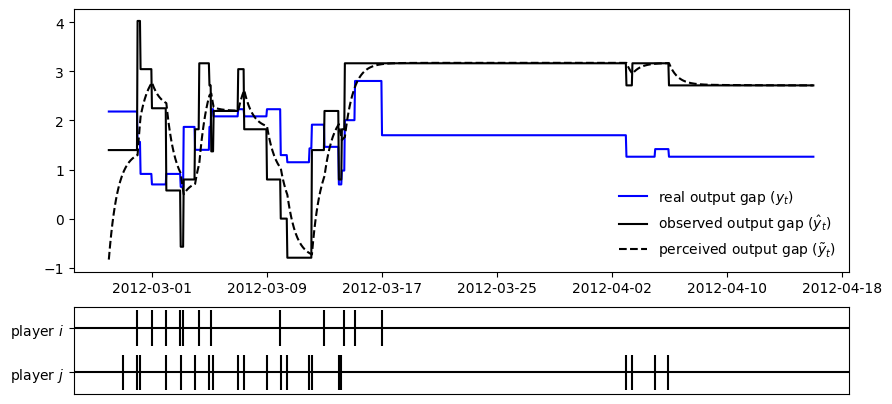

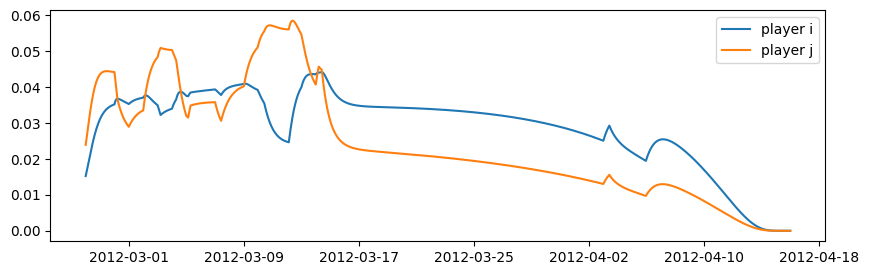

In [12]:
_ = plot_contest_data(contest_id)
plot_post_efforts(contest_id)

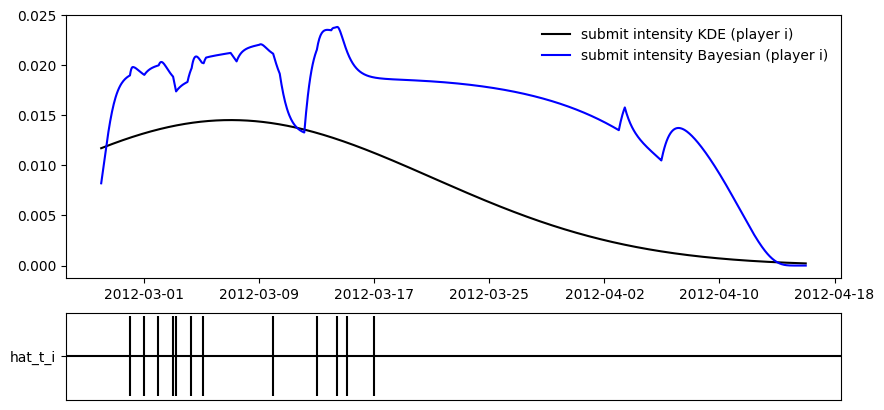

In [13]:
# Display submission intensity
contest_m_i = contest_data_post['m_i'].mean(axis=0)
contest_m_j = contest_data_post['m_j'].mean(axis=0)
contest_r = contest_data_post['r'].mean()
time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j = estimate_effort_kde(contest_id, 2)
_ = plot_ts_events(time_grids, ts={
	'submit intensity KDE (player i)': intensity_i,
	'submit intensity Bayesian (player i)': contest_m_i * contest_r / 24,
	#'submit intensity (player j)': intensity_j,
	#'effort level (player j)': contest_m_j,
}, events={
	'hat_t_i': hat_t_i,
	#'hat_t_j': hat_t_j,
}, ts_colors = ['black', 'blue', 'black', 'blue'], ts_linestyles = ['solid', 'solid', 'dashed', 'dashed'],
)

#### Validate $\sigma$

In [ ]:
sigma_hat_bayes = cross_contests['sigma_post_mean']
sigma_hat_mle = cross_contests['sigma_mle']
X_lamb = sm.add_constant(sigma_hat_bayes)
model_sigma = sm.OLS(sigma_hat_mle, X_lamb).fit()
sigma_hat_fit = model_sigma.predict(X_lamb)
display(model_sigma.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sigma_mle   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                   0.07305
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.789
Time:                        21:11:06   Log-Likelihood:                -28.378
No. Observations:                  32   AIC:                             60.76
Df Residuals:                      30   BIC:                             63.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1754      0.235      4.996      0.000       0.695       1.656
sigma_post_mean     0.0489      0.181      0.270      0.789      -0.320       0.418
==============================================================================
Omnibus:                        1.948   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.201
Skew:                           0.471   Prob(JB):                        0.549
Kurtosis:                       3.120   Cond. No.                         4.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

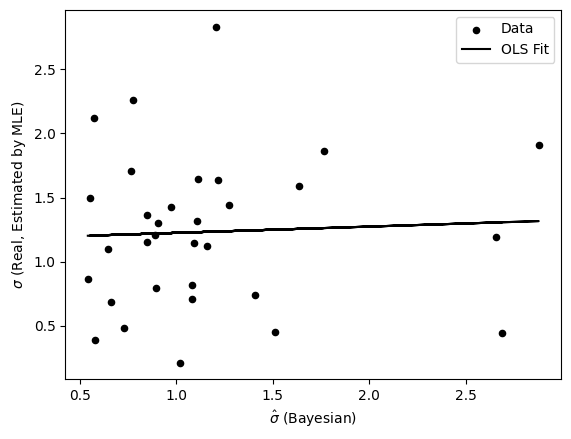

In [15]:
plt.scatter(sigma_hat_bayes, sigma_hat_mle, s=20, label="Data", color="black", )
plt.plot(sigma_hat_bayes, sigma_hat_fit, label="OLS Fit", color="black")
plt.legend()
plt.xlabel(r"$\hat\sigma$ (Bayesian)")
plt.ylabel(r"$\sigma$ (Real, Estimated by MLE)")
plt.show()

In [ ]:
outlier_test_result = model_sigma.outlier_test(method='bonf', alpha=0.1)
non_outliers = outlier_test_result['bonf(p)'] > 0.05
outliers = outlier_test_result['bonf(p)'] <= 0.05
X_sigma_clean = X_lamb[non_outliers]
y_sigma_clean = sigma_hat_mle[non_outliers]
model_sigma_clean = sm.OLS(y_sigma_clean, X_sigma_clean).fit()
sigma_hat_fit_clean = model_sigma_clean.predict(X_lamb)
display(model_sigma_clean.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sigma_mle   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                   0.07305
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.789
Time:                        21:11:12   Log-Likelihood:                -28.378
No. Observations:                  32   AIC:                             60.76
Df Residuals:                      30   BIC:                             63.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1754      0.235      4.996      0.000       0.695       1.656
sigma_post_mean     0.0489      0.181      0.270      0.789      -0.320       0.418
==============================================================================
Omnibus:                        1.948   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.201
Skew:                           0.471   Prob(JB):                        0.549
Kurtosis:                       3.120   Cond. No.                         4.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

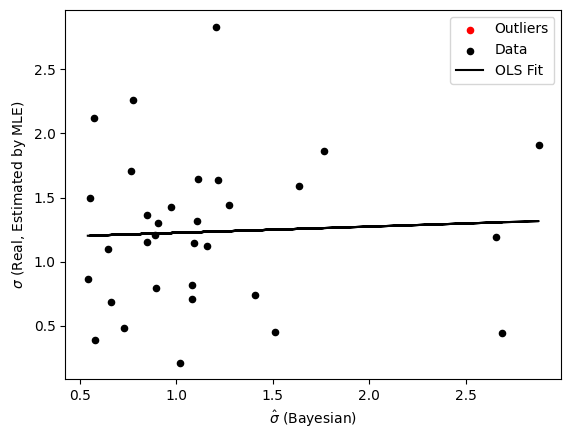

In [17]:
plt.scatter(sigma_hat_bayes[outliers], sigma_hat_mle[outliers], s=20, label="Outliers", color="red", )
plt.scatter(sigma_hat_bayes[non_outliers], sigma_hat_mle[non_outliers], s=20, label="Data", color="black", )
plt.plot(sigma_hat_bayes, sigma_hat_fit_clean, label="OLS Fit", color="black")
plt.legend()
plt.xlabel(r"$\hat\sigma$ (Bayesian)")
plt.ylabel(r"$\sigma$ (Real, Estimated by MLE)")
plt.show()

#### Validate $\lambda$

In [39]:
lamb_hat_bayes = cross_contests['lambda_post_mean']
log_lamb_hat_real = np.log(1 + cross_contests['lambda_mle'])
X_lamb = sm.add_constant(lamb_hat_bayes)
model_lambda = sm.OLS(log_lamb_hat_real, X_lamb).fit()
log_lamb_hat_fit = model_lambda.predict(X_lamb)
display(model_lambda.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lambda_mle   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.1849
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.670
Time:                        21:17:29   Log-Likelihood:                -72.744
No. Observations:                  32   AIC:                             149.5
Df Residuals:                      30   BIC:                             152.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.6155      6.170      1.396      0.173      -3.985      21.216
lambda_post_mean    -0.3016      0.701     -0.430      0.670      -1.734       1.131
==============================================================================
Omnibus:                        1.540   Durbin-Watson:                   2.384
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.124
Skew:                          -0.195   Prob(JB):                        0.570
Kurtosis:                       2.168   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

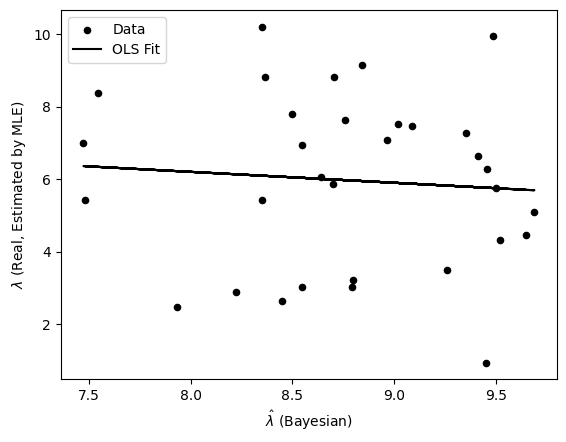

In [40]:
plt.scatter(lamb_hat_bayes, log_lamb_hat_real, s=20, label="Data", color="black", )
plt.plot(lamb_hat_bayes, log_lamb_hat_fit, label="OLS Fit", color="black")
plt.legend()
plt.xlabel(r"$\hat\lambda$ (Bayesian)")
plt.ylabel(r"$\lambda$ (Real, Estimated by MLE)")
plt.show()

In [45]:
outlier_test_result = model_lambda.outlier_test(method='bonf', alpha=0.05)
display(outlier_test_result)
non_outliers = outlier_test_result['bonf(p)'] > 0.05
outliers = outlier_test_result['bonf(p)'] <= 0.05
X_sigma_clean = X_lamb[non_outliers]
y_sigma_clean = log_lamb_hat_real[non_outliers]
model_sigma_clean = sm.OLS(y_sigma_clean, X_sigma_clean).fit()
sigma_hat_fit_clean = model_sigma_clean.predict(X_lamb)
display(model_sigma_clean.summary())

,student_resid,unadj_p,bonf(p)
0,-1.474669,0.151076,1.0
1,1.362657,0.183480,1.0
2,0.375953,0.709688,1.0
3,-2.188934,0.036800,1.0
4,0.361378,0.720436,1.0
5,0.220000,0.827412,1.0
6,0.278948,0.782264,1.0
7,-0.046225,0.963448,1.0
8,0.721714,0.476249,1.0
9,-1.394766,0.173679,1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lambda_mle   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.1849
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.670
Time:                        21:18:29   Log-Likelihood:                -72.744
No. Observations:                  32   AIC:                             149.5
Df Residuals:                      30   BIC:                             152.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.6155      6.170      1.396      0.173      -3.985      21.216
lambda_post_mean    -0.3016      0.701     -0.430      0.670      -1.734       1.131
==============================================================================
Omnibus:                        1.540   Durbin-Watson:                   2.384
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.124
Skew:                          -0.195   Prob(JB):                        0.570
Kurtosis:                       2.168   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

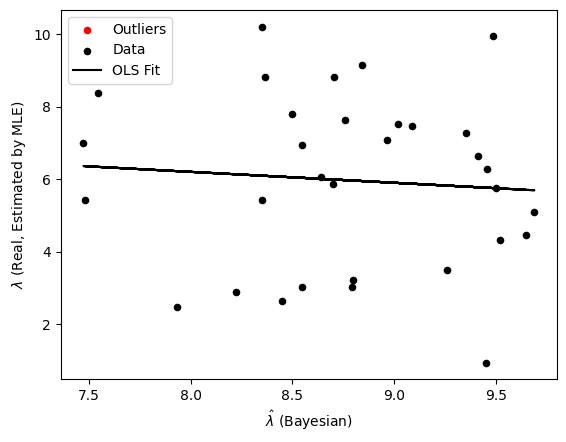

In [33]:
plt.scatter(lamb_hat_bayes[outliers], log_lamb_hat_real[outliers], s=20, label="Outliers", color="red", )
plt.scatter(lamb_hat_bayes[non_outliers], log_lamb_hat_real[non_outliers], s=20, label="Data", color="black", )
plt.plot(lamb_hat_bayes, sigma_hat_fit_clean, label="OLS Fit", color="black")
plt.legend()
plt.xlabel(r"$\hat\lambda$ (Bayesian)")
plt.ylabel(r"$\lambda$ (Real, Estimated by MLE)")
plt.show()